{0: <__main__.Node object at 0x000001FD3371F190>, 1: <__main__.Node object at 0x000001FD63D0BD00>, 2: <__main__.Node object at 0x000001FD63D0BD90>, 3: <__main__.Node object at 0x000001FD63D0BDF0>, 4: <__main__.Node object at 0x000001FD63D0BE50>, 5: <__main__.Node object at 0x000001FD63D0BEB0>, 6: <__main__.Node object at 0x000001FD63D0BF10>, 7: <__main__.Node object at 0x000001FD63D0BF70>, 8: <__main__.Node object at 0x000001FD63D0BFD0>, 9: <__main__.Node object at 0x000001FD63D54070>, 10: <__main__.Node object at 0x000001FD63D540D0>, 11: <__main__.Node object at 0x000001FD63D54130>, 12: <__main__.Node object at 0x000001FD63D54190>, 13: <__main__.Node object at 0x000001FD63D541F0>, 14: <__main__.Node object at 0x000001FD63D54250>, 15: <__main__.Node object at 0x000001FD63D542B0>, 16: <__main__.Node object at 0x000001FD63D54310>, 17: <__main__.Node object at 0x000001FD63D54370>, 18: <__main__.Node object at 0x000001FD63D543D0>, 19: <__main__.Node object at 0x000001FD63D54430>, 20: <__ma

C:\Users\mops\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


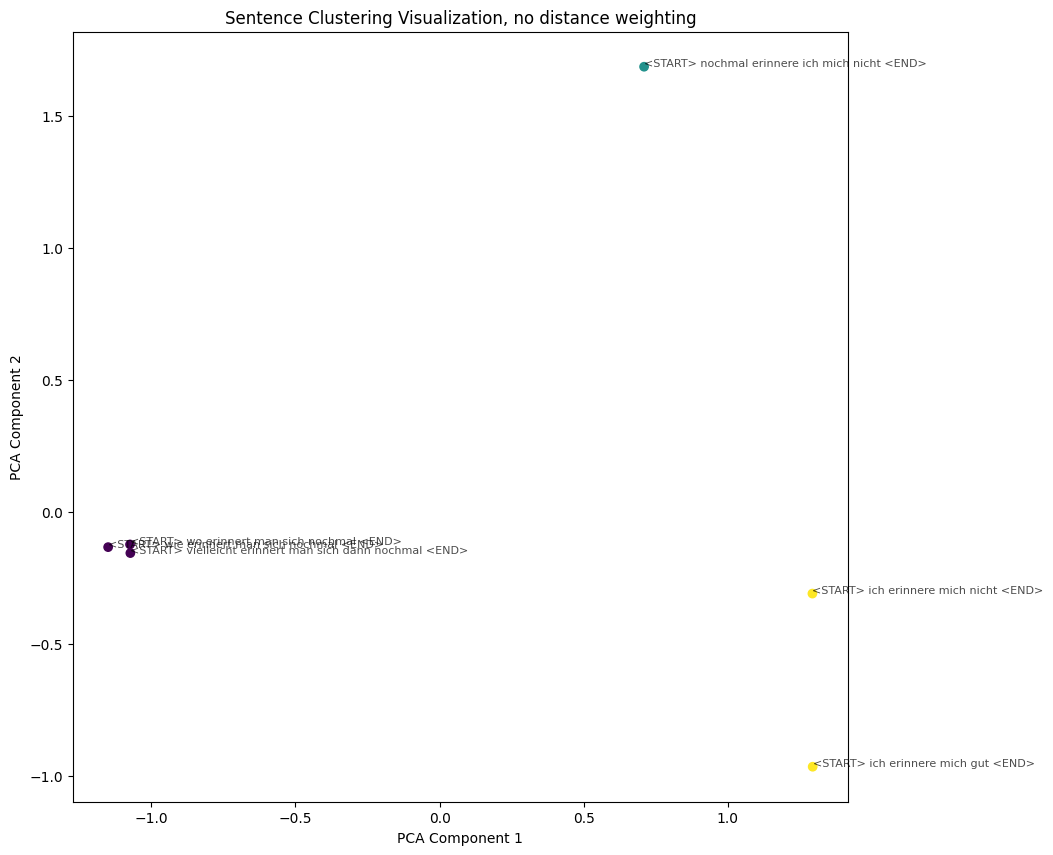

C:\Users\mops\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


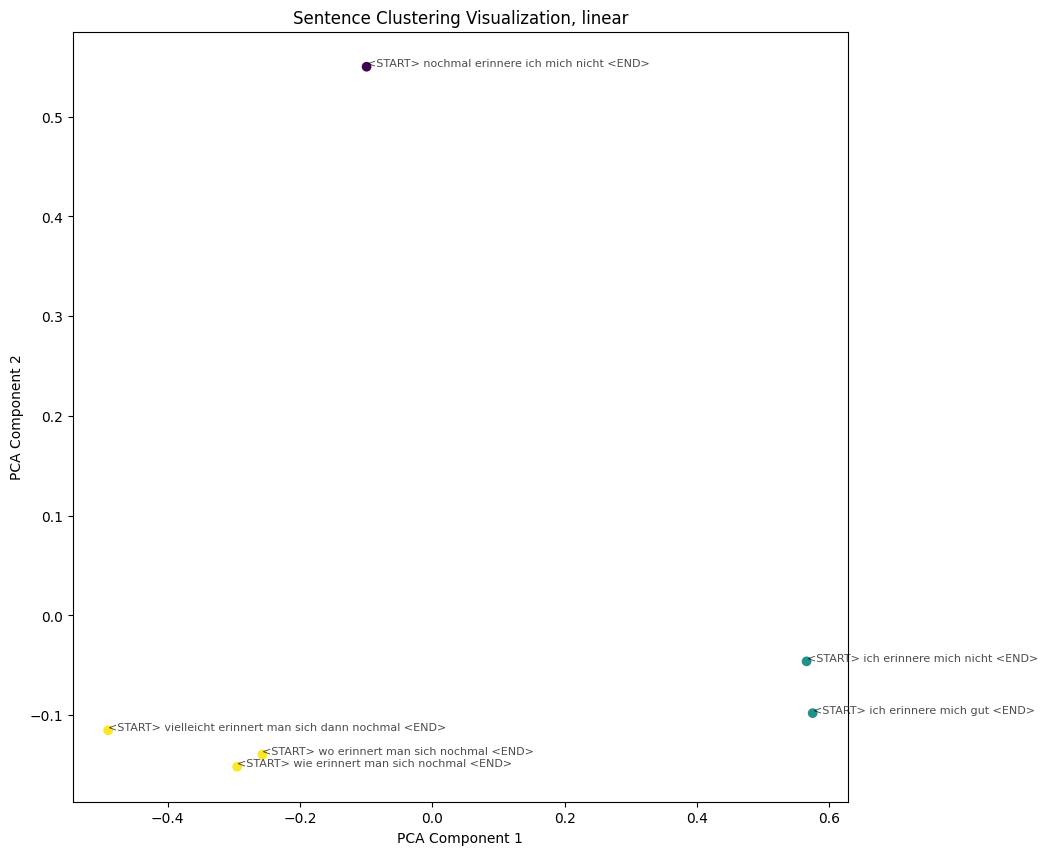

C:\Users\mops\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


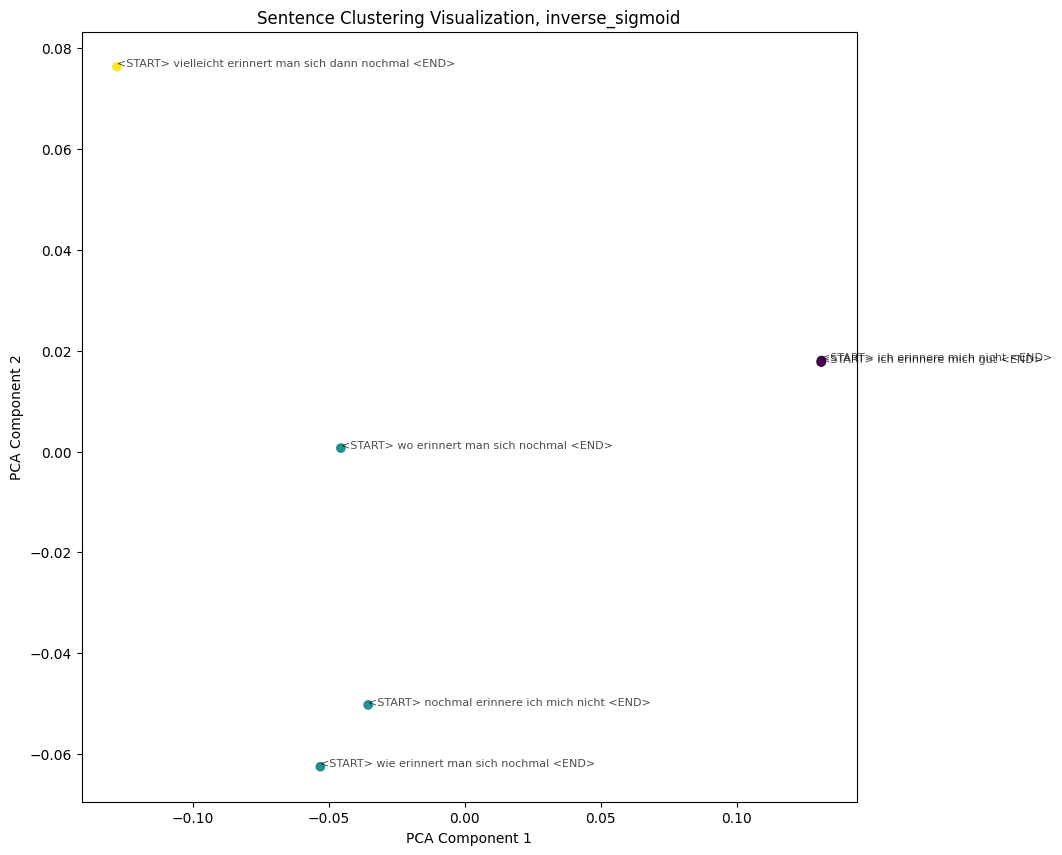

In [1]:
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict, deque

class Node:
    def __init__(self, word, id):
        self.word = word
        self.id = id
        self.count = 0
        self.children = {}

class PatternExtractor:
    def __init__(self):
        self.preceding_tree = Node('<ROOT>', 0)
        self.following_tree = Node('<ROOT>', 1)
        self.node_counter = 2
        self.word_to_ids = defaultdict(list)
        self.id_to_node = {0: self.preceding_tree, 1: self.following_tree}
        self.child_to_parents = defaultdict(list)
        self.node_embeddings = {}  # Store embeddings for each node

    def add_start_end_flags_lower(self, sentences):
        return [f"<START> {sentence.lower()} <END>" for sentence in sentences]

    def get_or_create_node(self, current_tree, word, parent_id=None):
        if word not in current_tree.children:
            new_node = Node(word, self.node_counter)
            current_tree.children[word] = new_node
            self.word_to_ids[word].append(self.node_counter)
            self.id_to_node[self.node_counter] = new_node
            if parent_id is not None and parent_id not in self.child_to_parents[self.node_counter]:
                self.child_to_parents[self.node_counter].append(parent_id)
            self.node_counter += 1
        else:
            child_id = current_tree.children[word].id
            if parent_id is not None and parent_id not in self.child_to_parents[child_id]:
                self.child_to_parents[child_id].append(parent_id)
        return current_tree.children[word]

    def add_to_tree(self, words, direction, count=1):
        current_tree = self.preceding_tree if direction == 'preceding' else self.following_tree
        if direction == 'preceding':
            word_range = range(len(words) - 1, -1, -1)
        else:
            word_range = range(len(words))

        parent_id = current_tree.id

        for i in word_range:
            current_word = words[i]
            current_tree = self.get_or_create_node(current_tree, current_word, parent_id)
            current_tree.count += count
            parent_id = current_tree.id

    def create_tree_mask_as_root(self, sentences_dict):
        for morphology, sentences in sentences_dict.items():
            sentences_with_flags = self.add_start_end_flags_lower(sentences)

            for sentence in sentences_with_flags:
                words = sentence.split()
                key_word_index = words.index(morphology.lower())
                words_before = words[:key_word_index]
                words_after = words[key_word_index + 1:]

                self.add_to_tree(words_before, 'preceding')
                self.add_to_tree(words_after, 'following')

    def print_tree(self, node, level=0):
        print('  ' * level + f"{node.word} (count: {node.count}, id: {node.id})")
        for child in node.children.values():
            self.print_tree(child, level + 1)

    def print_trees(self):
        print("Preceding Tree (before <MASK>):")
        self.print_tree(self.preceding_tree)
        print("\nFollowing Tree (after <MASK>):")
        self.print_tree(self.following_tree)

    def get_nodes_by_word(self, word):
        ids = self.word_to_ids.get(word, [])
        return {self.id_to_node[id] for id in ids}

    def get_node_by_id(self, id):
        return self.id_to_node.get(id)

    def get_parents_by_id(self, id):
        parent_ids = self.child_to_parents.get(id, [])
        return [self.id_to_node[parent_id] for parent_id in parent_ids]

    def optimize_tree(self, word):
        all_nodes = self.get_nodes_by_word(word)
        groups_with_same_children = defaultdict(list)
        for node in all_nodes:
            child_structure = frozenset((child.word, child.id) for child in node.children.values())
            groups_with_same_children[child_structure].append(node)
        for node_group in [i for i in groups_with_same_children.values() if len(i) > 1]:
            node_with_smallest_id = min(node_group, key=lambda node: node.id)
            parents = []
            for node in node_group:
                if node != node_with_smallest_id:
                    parents.extend(self.get_parents_by_id(node.id))
                    node_with_smallest_id.children.update(node.children)
            for parent_node in parents:
                parent_node.children[word] = node_with_smallest_id
            for parent in parents:
                self.optimize_tree(parent.word)

    def initialize_node_embeddings(self, embedding_size=100):
        """
        Initialize random embeddings for each node.
        """
        for node_id in self.id_to_node.keys():
            self.node_embeddings[node_id] = np.random.rand(embedding_size)

    def compute_weighted_sentence_embedding(self, sentence_path, weighting_scheme = None):
        """
        Compute a weighted sentence embedding by traversing the sentence path.
        Nodes closer to the root are weighted more heavily.
        """
        weighted_embedding = np.zeros(len(self.node_embeddings[0]))  # Assuming all embeddings have the same size
        for i, node_id in enumerate(sentence_path):
            if weighting_scheme == 'linear':
                distance_from_root = i + 1
                weight = 1 / distance_from_root
            elif weighting_scheme == 'inverse_sigmoid':
                distance_from_root = i + 1  # Assuming sentence_path is ordered from ROOT
                steepness = 1
                weight = 1 - (1 / (1 + np.exp(-steepness * distance_from_root)))
            else:
                weight = 1
            weighted_embedding += weight * self.node_embeddings[node_id]
        return weighted_embedding / len(sentence_path)

    def get_sentence_embedding(self, sentence, morphology, weighting_scheme = None):
        """
        Given a sentence, return its corresponding embedding.
        """

        words = sentence.split()
        node_path = deque([0])
        key_word_index = words.index(morphology.lower())
        words_before = words[:key_word_index]
        words_after = words[key_word_index + 1:]

        current_node = self.preceding_tree
        for i in range(len(words_before) - 1, -1, -1):
            word = words_before[i]
            if word in current_node.children:
                current_node = current_node.children[word]
                node_path.appendleft(current_node.id)
            else:
                raise

        current_node = self.following_tree
        for word in words_after:
            if word in current_node.children:
                current_node = current_node.children[word]
                node_path.append(current_node.id)
            else:
                raise
        return self.compute_weighted_sentence_embedding(node_path, weighting_scheme=weighting_scheme)

    def get_all_sentence_embeddings(self, sentences_dict, weighting_scheme=None):
        """
        Generate embeddings for all sentences in the dataset.
        """
        sentence_embeddings = []
        sentence_list = []
        for morphology, sentences in sentences_dict.items():
            sentences_with_flags = self.add_start_end_flags_lower(sentences)
            for sentence in sentences_with_flags:
                embedding = self.get_sentence_embedding(sentence, morphology, weighting_scheme=weighting_scheme)
                sentence_embeddings.append(embedding)
                sentence_list.append(sentence)
        return np.array(sentence_embeddings), sentence_list

    def cluster_sentences(self, embeddings, n_clusters=3):
        """
        Apply K-Means clustering to sentence embeddings.
        """
        kmeans = KMeans(n_clusters=n_clusters)
        clusters = kmeans.fit_predict(embeddings)
        return clusters

    def reduce_dimensionality(self, embeddings, n_components=2):
        """
        Reduce dimensionality of embeddings for visualization.
        """
        pca = PCA(n_components=n_components)
        reduced_embeddings = pca.fit_transform(embeddings)
        return reduced_embeddings

    def visualize_clusters(self, reduced_embeddings, clusters, sentence_list, title_appendix=None):
        """
        Visualize clusters using a 2D plot.
        """
        plt.figure(figsize=(10, 10))
        scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis')
        # plt.colorbar(scatter)

        # Annotate sentences for better interpretability
        for i, sentence in enumerate(sentence_list):
            plt.annotate(sentence, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=8, alpha=0.7)

        plt.title(f"Sentence Clustering Visualization{', '+title_appendix if title_appendix else ''}")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")
        plt.show()

# Create a PatternExtractor instance
extractor = PatternExtractor()
sentences_dict = {
    'erinnere': [
        'Ich erinnere mich gut',
        'ich erinnere mich nicht',
        'nochmal erinnere ich mich nicht'
    ],
    'erinnert': [
        'wie erinnert man sich nochmal',
        'wo erinnert man sich nochmal',
        'vielleicht erinnert man sich dann nochmal'
    ]
}

# sentences_dict = {
#     'erinnere': [
#         'Ich erinnere mich gut',
#         'ich erinnere mich nicht',
#         'nochmal erinnere ich mich nicht',
#         'ich erinnere mich an das Treffen gestern',
#         'erinnere mich bitte daran, morgen früh aufzustehen',
#         'ich erinnere mich an die schöne Zeit'
#     ],
#     'erinnert': [
#         'wie erinnert man sich nochmal',
#         'wo erinnert man sich nochmal',
#         'vielleicht erinnert man sich dann nochmal',
#         'erinnert mich an meine Kindheit',
#         'sie erinnert sich nicht mehr an das Gespräch',
#         'er erinnert sich nicht gerne an die Vergangenheit'
#     ],
#     'erinnerte': [
#         'er erinnerte sich plötzlich an den Vorfall',
#         'ich erinnerte mich an mein erstes Auto',
#         'sie erinnerte sich, dass sie etwas vergessen hatte',
#         'erinnerte ich mich an den alten Freund',
#         'er erinnerte sich an die Worte seiner Mutter',
#         'ich erinnerte mich an den letzten Urlaub'
#     ]
# }

# Build the trees from the sentences
extractor.create_tree_mask_as_root(sentences_dict)
print(extractor.id_to_node)

extractor.optimize_tree('<START>')
extractor.optimize_tree('<END>')

extractor.print_trees()

# Initialize embeddings
extractor.initialize_node_embeddings(embedding_size=500)
extractor.id_to_node
# Step 1: Generate embeddings for all sentences

for weighting_scheme in ['no distance weighting', 'linear', 'inverse_sigmoid']:
    sentence_embeddings, sentence_list = extractor.get_all_sentence_embeddings(sentences_dict, weighting_scheme=weighting_scheme)
    n_clusters = 3  # You can adjust this based on the number of clusters you want
    clusters = extractor.cluster_sentences(sentence_embeddings, n_clusters=n_clusters)
    reduced_embeddings = extractor.reduce_dimensionality(sentence_embeddings)
    extractor.visualize_clusters(reduced_embeddings, clusters, sentence_list, title_appendix=weighting_scheme)

In [11]:
# def visualize_clusters_sequentially(reduced_embeddings, clusterings, sentence_list):
#     """
#     Visualize clusters using a 2D plot for each clustering method in sequence.
#     """
#     for method, clusters in clusterings.items():
#         plt.figure(figsize=(10, 7))
#         scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis')
#         plt.colorbar(scatter)

#         # Annotate sentences for better interpretability
#         for i, sentence in enumerate(sentence_list):
#             plt.annotate(sentence, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=8, alpha=0.7)

#         plt.title(f"Sentence Clustering Visualization ({method})")
#         plt.xlabel("PCA Component 1")
#         plt.ylabel("PCA Component 2")
#         plt.show()

# def visualize_clusters_grid(reduced_embeddings, clusterings, sentence_list):
#     """
#     Visualize clusters using a grid of subplots for each clustering method.
#     """
#     n_methods = len(clusterings)
#     fig, axes = plt.subplots(1, n_methods, figsize=(15, 7), sharex=True, sharey=True)

#     for ax, (method, clusters) in zip(axes, clusterings.items()):
#         scatter = ax.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=clusters, cmap='viridis')
#         fig.colorbar(scatter, ax=ax)

#         # Annotate sentences for better interpretability
#         for i, sentence in enumerate(sentence_list):
#             ax.annotate(sentence, (reduced_embeddings[i, 0], reduced_embeddings[i, 1]), fontsize=8, alpha=0.7)

#         ax.set_title(f"{method} Clustering")
#         ax.set_xlabel("PCA Component 1")
#         ax.set_ylabel("PCA Component 2")

#     plt.tight_layout()
#     plt.show()

# def apply_clustering_methods(embeddings):
#     """
#     Apply multiple clustering methods and return their results in a dictionary.
#     """
#     # K-Means Clustering
#     kmeans = KMeans(n_clusters=3)
#     kmeans_labels = kmeans.fit_predict(embeddings)

#     # Agglomerative Clustering
#     agglomerative = AgglomerativeClustering(n_clusters=3)
#     agglo_labels = agglomerative.fit_predict(embeddings)

#     # DBSCAN Clustering
#     dbscan = DBSCAN(eps=0.5, min_samples=2)
#     dbscan_labels = dbscan.fit_predict(embeddings)

#     return {
#         "KMeans": kmeans_labels,
#         "Agglomerative": agglo_labels,
#         "DBSCAN": dbscan_labels
#     }

# # Step 1: Generate embeddings for all sentences
# sentence_embeddings, sentence_list = extractor.get_all_sentence_embeddings(sentences_dict)

# # Step 2: Apply multiple clustering methods and get a dictionary with results
# clusterings = apply_clustering_methods(sentence_embeddings)

# # Step 3: Reduce dimensionality of embeddings for visualization
# reduced_embeddings = extractor.reduce_dimensionality(sentence_embeddings)

# # Step 4: Visualize clusters sequentially (one plot after the other)
# visualize_clusters_sequentially(reduced_embeddings, clusterings, sentence_list)

# # Step 5: Visualize clusters in a grid format
# visualize_clusters_grid(reduced_embeddings, clusterings, sentence_list)
